
This is my replication of Jorge M's model in Python, local version EEI. Hector June 2020


# >>>>>>>>>>>>>>>>>>>>>>>>CLEANING<<<<<<<<<<<<<<<<<<<<<<<<<<

In [1]:
# libraries
import numpy as np
import numpy.matlib
import pandas 
import scipy.io as sio
import brian2

In [172]:
#Graphic
import matplotlib.pyplot as plt
from matplotlib import cm
width_in_inches = 12
height_in_inches = 8
dots_per_inch = 70

# 1. Theory


I define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{syn,E} - b}{1 - e^{-d(aI_{syn,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = \frac{1}{g_2}(c_II_{syn,I} - c_0) + r_0 & \text{for } r_I\ge 0\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$

In [3]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_E']
        b = parameters['b_E']
        d = parameters['d_E']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'I':
        c_I = parameters['c_I']
        g_2 = parameters['g_2']
        r_0 = parameters['r0_I']
        c_0 = parameters['c_0']
        r = np.maximum((1/g_2)*(c_I*input_current - c_0) + r_0,0)
        return r
        # NOTE: using python broadcasting for ones subtraction, so should work for multi-area case too

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [4]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [5]:
def GABA_deriv(S_GABA_prev,rate_now,parameters):
    return -S_GABA_prev/parameters['tau_GABA'] + parameters['gammai']*rate_now

# 2. Set Parameters

In [207]:
parameters = {}
parameters.update({'SF1': 0.5, # Jorge M scaling factor to keep rates in check
                    'SF2': 2})    # Jorge M scaling factor to keep rates in check
                   
parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_AMPA': 0.002  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 
                    # f-I curve parameters - E populations
                    'a_E': 270. *parameters['SF1']  * brian2.Hz/brian2.nA,  # Hz/nA
                    'b_E': 108. *parameters['SF1']  * brian2.Hz,            # Hz
                    'd_E': 0.154*parameters['SF2']  * brian2.second,        # s
                    'gam': 0.641*parameters['SF2'],                         # unitless
                    # f-I curve parameters - I populations
                    'g_2': 1/(0.5*parameters['SF1']),                    # unitless
                    'c_I': 615  * brian2.Hz/brian2.nA,                 # Hz/nA
                    'c_0': 177  * brian2.Hz,                           # Hz
                    'gammai': parameters['SF2'],                       # unitless
                    # Local connectivity matrix strengths
    
                    # Strength of connections from E cells
                    'g_E_self': 0.48 * brian2.nA ,        # nA --> I_local_grad_NMDA
                    'g_E_cross': 0.0107* brian2.nA,         # nA --> J_NMDA --> I_local_nongrad_NMDA
                    # Strength of connections from I cells
                    'g_E_I':  -0.31   * brian2.nA,         # nA --> J_GABA --> I_local_GABA
                    'g_Iself': -0.12  * brian2.nA,         # nA --> J_GABA --> I_local_GABA
                    'g_I_E': 233 * brian2.pA,               #pA
                    # Background inputs
                    'I0_E': 0.3294     * brian2.nA,         # nA
                    'I0_I': 0.26       * brian2.nA,         # nA
                    # Noise std dev
                    'std_noise': 0.01 * brian2.nA,         # nA      
                    # initial values
                    'r0_E': 5 * brian2.Hz,
                    'r0_I': 11*parameters['SF1'] * brian2.Hz
                        })      
parameters.update({ # Zetas
                    'zeta': parameters['c_I']*parameters['g_E_I']*parameters['tau_GABA']*parameters['gammai']\
                            /(parameters['g_2'] - parameters['g_Iself']*parameters['tau_GABA']*parameters['gammai']*parameters['c_I']),
                    'zeta2': 2*parameters['c_I']*parameters['tau_GABA']*parameters['gammai']*parameters['g_E_I']\
                            /(parameters['c_I']*parameters['tau_GABA']*parameters['gammai']*parameters['g_Iself'] - parameters['g_2']),
                        })    
parameters.update({'S0': 0}) # #initial S_NMDA and S_GABA
parameters.update({'dt': 0.5 * brian2.ms}) 

parameters.update({'trial_length': 10 * brian2.second,
                   'start_time': 0 *brian2.second, # s
                   'end_time': 10 *brian2.second}) 

# 2 Connectivity

## Cortical connectivity

In [208]:
######## LOCAL ########
J =  np.array([[parameters['g_E_self']    , parameters['g_E_cross'], parameters['g_I_E']],
              [parameters['g_E_cross']    , parameters['g_E_self'],  parameters['g_I_E']],
               [parameters['g_E_I'],parameters['g_E_I'],parameters['g_Iself'] ]]).T * brian2.amp

#plot
pops = ['E1','E2','I']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

df_J = pandas.DataFrame(J , columns=pops_column_list, index=pops_row_list)

J_NMDA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

display(df_J)

,from E1,from E2,from I
to E1,4.800000e-10,1.070000e-11,-3.100000e-10
to E2,1.070000e-11,4.800000e-10,-3.100000e-10
to I,2.330000e-10,2.330000e-10,-1.200000e-10


In [209]:
display(J_NMDA)

array([[480. ,  10.7,  -0. ],
       [ 10.7, 480. ,  -0. ],
       [233. , 233. ,  -0. ]]) * pamp

In [210]:
display(J_GABA)

array([[   0.,    0., -310.],
       [   0.,    0., -310.],
       [   0.,    0., -120.]]) * pamp

# 3 Model class

In [211]:
class Model(object,):
    def __init__(self, parameter,n_trial=1):
        self.parameters = parameter.copy()       # Model parameters
        self.n_trial = n_trial

    def run(self):
        self.__init__(self.parameters)
       
        # Set up simulation parameters
        self.dt= self.parameters['dt']   # timestep 
        self.num_iterations = int(self.parameters['trial_length']/self.dt)
        num_iterations =  self.num_iterations
        time = np.arange(0, self.parameters['trial_length'], self.parameters['dt'])
      
        #local parameters
        num_areas = 1 #local
        num_pops  = 3
        num_E_pops = 2
        pops = ['E_1','E_2','I']

        # Choose initial values for rates and synapse variables
        R0vec = np.array([self.parameters['r0_E'],self.parameters['r0_E'],self.parameters['r0_E']])
        R0 = np.matlib.repmat(R0vec, num_areas, 1) * brian2.Hz
        self.S_NMDA0 = self.parameters['S0']*np.concatenate((np.ones((num_areas,2)),np.zeros((num_areas,num_pops-2))), axis=1)
        self.S_GABA0 = self.parameters['S0']*np.concatenate((np.zeros((num_areas,2)),np.ones((num_areas,num_pops-2))), axis=1)

        # Preassign rate and synapse matrices
        self.R = np.zeros((num_iterations,num_areas,num_pops)) * brian2.Hz
        self.R[0,:,:] = R0
        self.S_NMDA = np.zeros((num_iterations,num_areas,num_pops))
        self.S_NMDA[0,:,:] =  self.S_NMDA0
        self.S_GABA = np.zeros((num_iterations,num_areas,num_pops))
        self.S_GABA[0,:,:] =  self.S_GABA0
        
        # Choose stimulus and distractor strength
        stim_strength = self.parameters['stim_strength']
        distractor_strength = self.parameters['distractor_strength']

        # Preassign external inputs
        I_ext      = np.zeros((num_iterations,num_areas,num_pops)) * brian2.amp
        self.stim_on    = self.parameters['stim_on'] 
        self.stim_off   = self.parameters['stim_off'] 
        self.distraction_on  = self.parameters['distraction_on']
        self.distraction_off = self.parameters['distraction_off']

        # External input applied to  E1
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),0,pops.index('E_1')] = stim_strength
        # External distraction applied to E2
        I_ext[int(self.distraction_on/self.dt):int(self.distraction_off/self.dt),0,pops.index('E_2')] = distractor_strength

        # Create matrices in which we can store the currents
        I_local_NMDA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        I_local_grad_NMDA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        I_local_GABA =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        self.I_total      =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
        
        # Define background inputs
        I_0 = np.zeros((num_areas,num_pops)) * brian2.pA
        I_0[:,[pops.index('E_1'),pops.index('E_2')]] = self.parameters['I0_E']
        I_0[:,pops.index('I')] = self.parameters['I0_I']


        # NOISE
        eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_areas,num_pops ))
        noise_rhs = eta*((np.sqrt(self.parameters['tau_AMPA']*np.power(self.parameters['std_noise'],2))*np.sqrt(self.dt))/self.parameters['tau_AMPA'])
        noise_rhs[:,:,2] = 0 # Jorge only put noise on the E pops
        I_noise = np.zeros((num_areas , num_pops )) *brian2.pA
        
        for i_t in range(1,num_iterations):
            
            # update noise 
            I_noise = I_noise + -I_noise*(self.dt/self.parameters['tau_AMPA']) + noise_rhs[i_t-1,:,:]
            # local  NMDA
            I_local_NMDA[i_t-1,:,:] = J_NMDA.dot(self.S_NMDA[i_t-1,:,:].T).T
            # local GABA 
            I_local_GABA[i_t-1,:,:] = J_GABA.dot(self.S_GABA[i_t-1,:,:].T).T
            # Define total input current 
            self.I_total[i_t-1,:,:] = I_local_NMDA[i_t-1,:,:] + I_local_grad_NMDA[i_t-1,:,:] + I_local_GABA[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:]  + I_noise * self.parameters['turn_noise']

            # Update the firing rates of the two excitatory populations.
            self.R[i_t,:,:2] = self.R[i_t-1,:,:2] + self.dt*current_to_frequency(self.I_total[i_t-1,:,:2],'E',self.parameters)/self.parameters['tau_AMPA'] -self.dt*self.R[i_t-1,:,:2]/self.parameters['tau_AMPA']
            # Update the firing rates of the inhibitory population. 
            self.R[i_t,:,2] =  self.R[i_t-1,:,2] + self.dt*current_to_frequency(self.I_total[i_t-1,:,2],'I',self.parameters)/self.parameters['tau_AMPA'] -self.dt*self.R[i_t-1,:,2]/self.parameters['tau_AMPA']
            # Update the NMDA synapses
            self.S_NMDA[i_t,:,:2] = self.S_NMDA[i_t-1,:,:2] + self.dt*NMDA_deriv(self.S_NMDA[i_t-1,:,:2],self.R[i_t,:,:2],self.parameters)
            # Update the GABA synapses
            self.S_GABA[i_t,:,2] = self.S_GABA[i_t-1,:,2] + self.dt*GABA_deriv(self.S_GABA[i_t-1,:,2],self.R[i_t,:,2],self.parameters)

    def draw(self,):
        self.__init__(self.parameters)
        
        fig=plt.figure(figsize=(16,8), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})
        ax = plt.subplot(1,2,1)
        plt.subplots_adjust(hspace = 1)
        # Plot the rates for the E1 soma
        plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.R[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1),0,0],label = 'E1')
        # Plot the rates for the E2 soma
        plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.R[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1),0,1],label = 'E2')
        # Plot the rates for the I soma
        plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.R[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1),0,2],label = 'I')
        # Plot the stimulation time
        plt.plot([self.stim_on,self.stim_off],[np.max(self.R[:,0,:2]+0.15*np.max(self.R[:,0,:2])),np.max(self.R[:,0,:2]+0.15*np.max(self.R[:,0,:2]))],color='blue',linewidth=5.0)
        # Plot the distraction time
        plt.plot([self.distraction_on,self.distraction_off],[np.max(self.R[:,0,:2]+0.25*np.max(self.R[:,0,:2])),np.max(self.R[:,0,:2]+0.25*np.max(self.R[:,0,:2]))],color='red',linewidth=5.0)
        # place text above the black line
        axes = plt.gca()
        plt.legend(['E1','E2','I'])
        plt.xlabel('time (s)')
        plt.ylabel('firing rate (Hz)')
        plt.ylim(0, 60) 
        plt.legend()
        plt.show()

## Run model

In [212]:
p_0 = parameters.copy()

p_0.update({'distractor_strength':0 * brian2.nA,
            'stim_strength':0.1 * brian2.nA
           })

p_0.update({'distraction_on': 4 * brian2.second,
            'distraction_off':4.5 * brian2.second,
            'stim_on': 4 * brian2.second,
            'stim_off': 4.5 * brian2.second,
                  })
p_0.update({'turn_noise':0
                  })

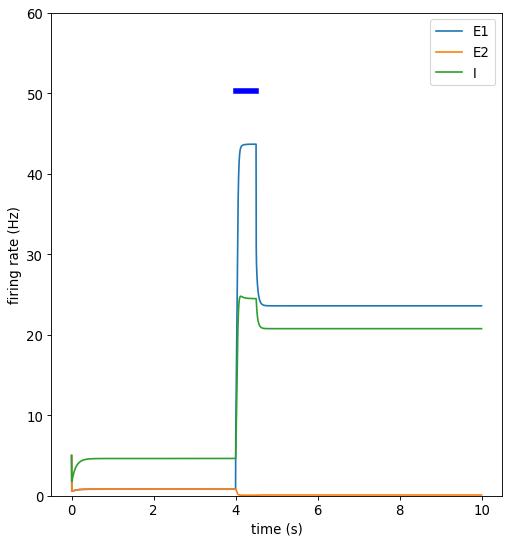

In [213]:
model_0 = Model(p_0)
model_0.run()
fig = model_0.draw()

# Fine tuning to get persistent activity

In [138]:
def fine_tuning(parameter,par_list = np.arange(0,0.5,0.1)):
    for p, par in enumerate(par_list):
        print('distractor_strength =', par)
        p_1 = parameter.copy()
        p_1.update({'distractor_strength': par * brian2.nA})
        model_1 = Model(p_1)
        model_1.run()
        fig = model_1.draw()
    return 
  

distractor_strength = 0.0


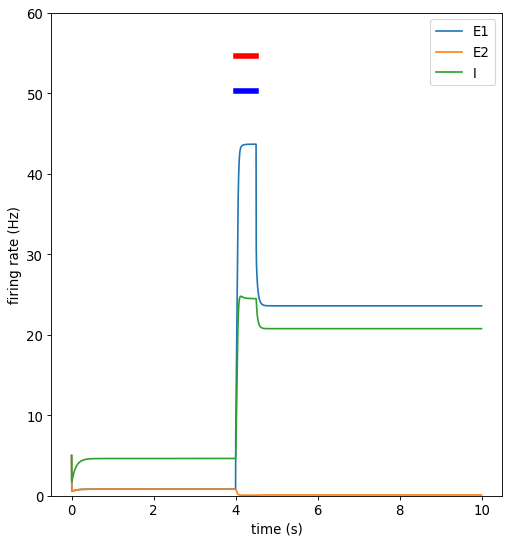

distractor_strength = 0.002


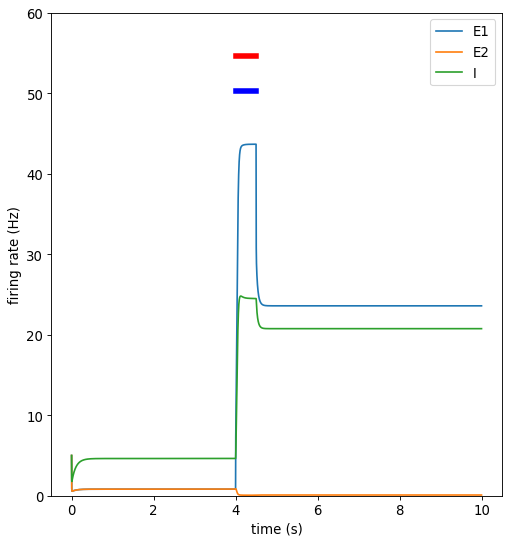

distractor_strength = 0.004


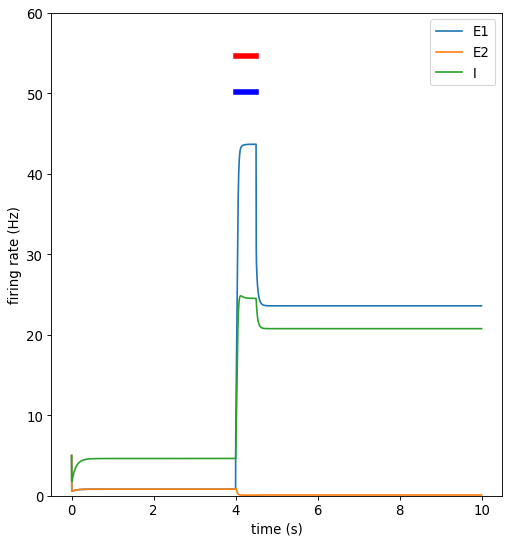

distractor_strength = 0.006


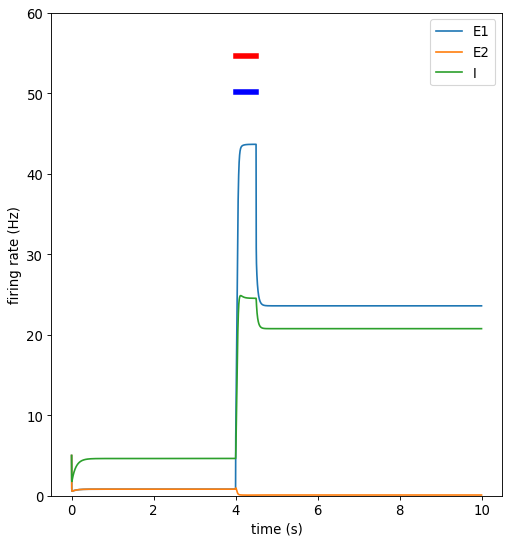

distractor_strength = 0.008


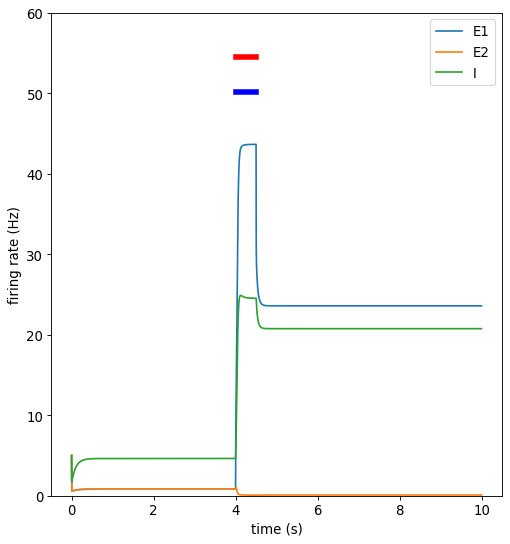

In [142]:
l = np.arange(0,0.01,0.002)

fine_tuning(p_0,l)

# Steady states

In [163]:
area_list = ['Local']

In [249]:
def steady_state_firing_rate(p):
    model = Model(p)
    model.run()   
    steady_FR = model.R[-1,:,:] # steady state activity rate
    return steady_FR

In [232]:
def st_FR_diff_strength(parameter,stim_list = np.arange(0,0.1,0.02)):
    steady_state_firing_rate_list = np.zeros((len(stim_list),1,3)) #UPDATE HERE
    for a, alpha in enumerate(stim_list):
        print('stim =', alpha)
        p = parameter.copy()
        p.update({'stim_strength': alpha * brian2.nA})
        steady_FR = steady_state_firing_rate(p)
        steady_state_firing_rate_list[a,:,:] = steady_FR #UPDATE HERE

    return steady_state_firing_rate_list

In [168]:
#good for different areas
def plot_st_FR_strength(stage,steady_state_firing_rate_list,stim_list):
    plt.rcParams.update({'font.size': 20})

    # generate dataframe
    df_st_FR_E1 = pandas.DataFrame(steady_state_firing_rate_list[:,:,0], columns = area_list)
    df_st_FR_E2 = pandas.DataFrame(steady_state_firing_rate_list[:,:,1], columns = area_list)
    df_st_FR_I  = pandas.DataFrame(steady_state_firing_rate_list[:,:,2], columns = area_list)
  
    
    fig = plt.figure(figsize = (25,16))
    for a, alpha in enumerate(stim_list):
        plt.plot(df_st_FR_E1.iloc[a,:],label= "Stimulation strength =  %.3f".format(alpha), c = cm.Blues(50+a*30), linewidth = 5)

    plt.xticks(rotation=90)
    plt.ylabel('Steady state firing rate (Hz)')
    plt.legend()

    for alpha in range(0,len(df_st_FR_E1)):
        plt.scatter(np.arange(0,40),df_st_FR_E1.iloc[alpha,:],s = 80,c = cm.Blues(50+alpha*30))

    plt.show()
    return fig

In [215]:
stim_list = np.arange(0.03,0.12,0.01)

df_st_FR = st_FR_diff_strength(p_0,stim_list)

stim = 0.03
stim = 0.04
stim = 0.05
stim = 0.060000000000000005
stim = 0.07
stim = 0.08000000000000002
stim = 0.09000000000000001
stim = 0.1
stim = 0.11000000000000001


In [216]:
def plot_st_FR_E1(df_st_FR, stim_list):
    
    fig = plt.figure(figsize = (5,5))
    df_st_FR_E1 = pandas.DataFrame(df_st_FR[:,:,0])
    plt.plot(stim_list,df_st_FR_E1, linewidth=0, marker='x')
    plt.xlabel('I_ext (nA)')
    plt.ylabel('E1 FR (Hz)')
    plt.show()
    return fig

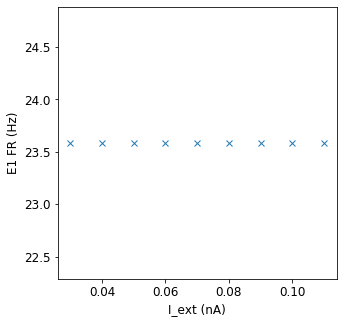

In [217]:
fig = plot_st_FR_E1(df_st_FR, stim_list)

### Add distraction

In [237]:
def st_FR_diff_strength_dist(parameter,stim_list = np.arange(0.03,0.12,0.03), dist_list=np.arange(0,0.3,0.1)):
    steady_state_firing_rate_list = np.zeros((len(dist_list),len(stim_list),3)) #UPDATE HERE
    for d, delta in enumerate(dist_list):
        print('dist_strength = ', delta)
        p = parameter.copy()
        p.update({'dist_strength' : delta * brian2.nA})
        print(p['dist_strength'])
        for a, alpha in enumerate(stim_list):
            print('stim =', alpha)
            p.update({'stim_strength': alpha * brian2.nA})
            steady_FR = steady_state_firing_rate(p)
            steady_state_firing_rate_list[d,a,:] = steady_FR #UPDATE HERE
    return steady_state_firing_rate_list

In [250]:
stim_list = np.arange(0.03,0.12,0.03)
dist_list = np.arange(0,0.2,0.05)

df_st_FR = st_FR_diff_strength_dist(p_0,stim_list, dist_list)

dist_strength =  0.0
0. A
stim = 0.03
stim = 0.06
stim = 0.09
dist_strength =  0.05
50. pA
stim = 0.03
stim = 0.06
stim = 0.09
dist_strength =  0.1
100. pA
stim = 0.03
stim = 0.06
stim = 0.09
dist_strength =  0.15000000000000002
150. pA
stim = 0.03
stim = 0.06
stim = 0.09


In [251]:
df_st_FR


array([[[23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889]],

       [[23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889]],

       [[23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889]],

       [[23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889],
        [23.58570873,  0.09532309, 20.75130889]]])

In [252]:
def plot_FR_diff_strength_dist_E1(df_st_FR, stim_list, dist_list):
    fig = plt.figure(figsize = (10,10))
    for i in range(len(dist_list)):
        df_st_dist_E1 = pandas.DataFrame(df_st_FR[i,:,0])
        plt.plot(stim_list,df_st_dist_E1, linewidth=0, marker='o')
        plt.xlabel('I_ext (nA)')
        plt.ylabel('E1 FR (Hz)')
    plt.legend(dist_list)
    plt.show()
    return 

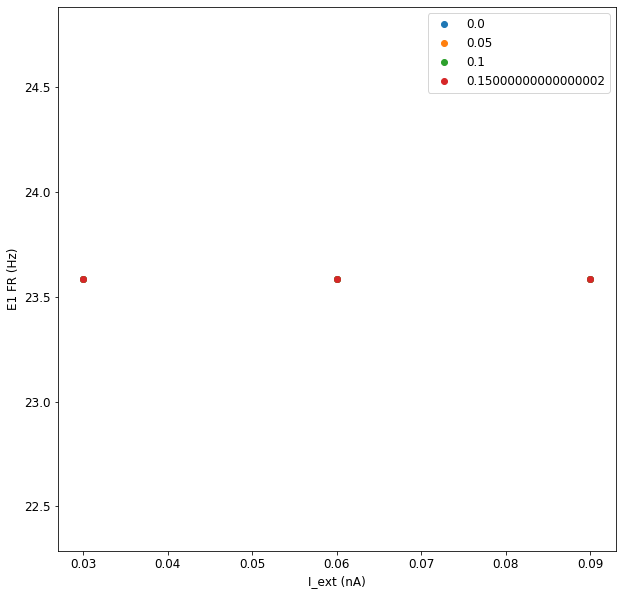

In [253]:
plot_FR_diff_strength_dist_E1(df_st_FR, stim_list,dist_list)